In [93]:
import numpy as np
import pandas as pd

# Classifiers and regressors
from sklearn.dummy import DummyClassifier

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import os

In [68]:
# Check that the dataset exists
print(os.listdir("data/"))

['van_weather_1990-01-01_2023-11-06.csv', 'van_weather_2013-01-01_2023-11-09_hr.csv']


In [69]:
daily_data = pd.read_csv('data/van_weather_1990-01-01_2023-11-06.csv')

In [70]:
daily_data.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,1990-01-01,51.0,5.7095,2.0095,3.903249,1.759364,-2.227180,0.155060,0,0,1.600000,1.600000,0.00,7.0,18.250260,35.280000,222.90671,4.09,0.504341
1,1990-01-02,71.0,3.0595,0.0095,1.959500,-0.347375,-2.789511,-1.547468,0,0,1.000000,0.700000,0.21,5.0,12.261158,28.800000,171.74966,3.29,0.467342
2,1990-01-03,73.0,4.4095,1.9595,2.934500,1.055596,-1.572106,-0.585330,0,0,11.400002,10.600001,0.56,24.0,17.555307,34.560000,141.70381,1.89,0.201307
3,1990-01-04,61.0,7.3595,3.2095,4.917833,3.778481,0.573077,1.792292,0,0,12.599999,12.599999,0.00,14.0,18.806337,38.160000,162.86450,2.43,0.277709
4,1990-01-05,63.0,8.3595,3.6595,5.892833,4.432674,0.000019,2.062605,0,0,17.699999,17.699999,0.00,17.0,32.919827,64.439995,159.80486,0.64,0.168201


We are trying to predict (rainfall) from other variables.

Taking a quick look at the target variables (the y)

Model A: predicting whether there is precipitation (rainfall + snowfall) from other variables

Model B: predicting whether there is snowfall from other variables


In [71]:
print("The total number of data we are looking at is:", daily_data.shape[0])

The total number of data we are looking at is: 12363


In [72]:
# Precipitation prediction is a classification problem with almost equal percentage of days with precipitation no precipiation
daily_data['is_precipitation'] = daily_data['precipitation_sum'] > 0.01
daily_data['is_precipitation'].value_counts()

is_precipitation
True     6828
False    5535
Name: count, dtype: int64

In [73]:
# Snowfall precipitation is a classification problem with very little positive data, we will take note of this inequality as we run the models.
daily_data['is_snow'] = daily_data['snowfall_sum'] > 0.01
daily_data['is_snow'].value_counts()


is_snow
False    11635
True       728
Name: count, dtype: int64

In [74]:
# There is no missing data: imputation not required. 
daily_data.isna().sum()

date                           0
weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_max       0
apparent_temperature_min       0
apparent_temperature_mean      0
sunrise                        0
sunset                         0
precipitation_sum              0
rain_sum                       0
snowfall_sum                   0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
is_precipitation               0
is_snow                        0
dtype: int64

In [75]:
print(list(daily_data.columns))

['date', 'weather_code', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'sunrise', 'sunset', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'is_precipitation', 'is_snow']


### A quick summary of variables

List of target variables:
- is_precipitation
- is_snow

List of variables to drop:
- Date: Using this will overcomplicate the current model. We may explore this in further study with time-series related models. 
- Weather code: This will say whether there is precipitation (e.g. code 20-29 means there is precipitation) 
- Select only 'temperature_2m_mean' out of all the temperature related variables, and 'wind_speed_10m_max' from ['wind_speed_10m_max', 'wind_gusts_10m_max'].

{Code definition: https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM}
- Precipitation_sum, rain_sum, snowfall_sum, precipitation_hours are dropped because they can be used to derive if there is precipiation/ snowfall directly. 
- Sunrise and sunset columns are dropped as they all show 0.

List of prediction variables:
- Month
- The rest of the columns

In [76]:
from datetime import datetime as dt

daily_data['date'] = pd.to_datetime(daily_data['date'])
daily_data['month'] = daily_data['date'].dt.month

# Using ordinal encoding  or leaving the month as a number may not be the best representation of month. 
# Since month is a cyclical data, we get inspiration from this work and use cyclical encoding: 
# https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning
# This preprocessing does not break golden rule because the max value of months is 12 as per common knowledge. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

daily_data = encode(daily_data, 'month', 12)
 

In [77]:
Usable_cols = ['temperature_2m_mean', 'wind_speed_10m_max', 
                'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 
               'is_precipitation', 'is_snow', 'month_sin', 'month_cos']
df = daily_data[Usable_cols].copy()
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=522)

#Here we train with target variables 'is_precipitation' first

X_train = train_df.drop(columns=['is_precipitation', 'is_snow'])
y_train = train_df['is_precipitation']
X_test = test_df.drop(columns=['is_precipitation', 'is_snow'])
y_test = test_df['is_precipitation']

X_train.head()


,temperature_2m_mean,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,month_sin,month_cos
4428,3.924084,7.594207,7.625911,10.56,1.169531,8.660254e-01,5.000000e-01
1182,6.765750,7.636753,144.196550,18.07,2.278618,1.000000e+00,6.123234e-17
12221,12.353417,21.398056,272.093350,26.07,3.796273,1.224647e-16,-1.000000e+00
4197,14.947000,8.311245,235.980600,31.24,4.915466,1.224647e-16,-1.000000e+00
7352,5.453250,12.758432,349.729030,11.33,1.357648,8.660254e-01,5.000000e-01


In [78]:
# Defining the function to calculate score for cross validation (credit to DSCI571)
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    print(out_col)
    return pd.Series(data=out_col, index=mean_scores.index)

In [79]:
# All the features are numerical features to be standardized. Here, we will use standard scalar.
preprocess = StandardScaler()

# We will evaluate a set of models for this project
models = {
    "dummy": DummyClassifier(random_state=522), 
    "Decision Tree": DecisionTreeClassifier(random_state=522),
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=522),
    "Logistic Regression": LogisticRegression(max_iter=2000, multi_class="ovr", random_state=522),
}

output_list = []

for model_name in models.keys():
    model = models[model_name]
    pipe = make_pipeline(preprocess, model)
    output_list.append(mean_std_cross_val_scores(pipe,X_train,y_train,return_train_score=True))   
    print("Done with", model_name)

results_df = pd.concat(output_list, axis=1)
results_df.columns = models.keys()
results_df = results_df.T
...
results_df

['0.001 (+/- 0.001)', '0.002 (+/- 0.001)', '0.553 (+/- 0.000)', '0.553 (+/- 0.000)']
Done with dummy


['0.070 (+/- 0.002)', '0.001 (+/- 0.000)', '0.797 (+/- 0.008)', '1.000 (+/- 0.000)']
Done with Decision Tree
['0.006 (+/- 0.001)', '0.038 (+/- 0.001)', '0.836 (+/- 0.007)', '0.885 (+/- 0.002)']
Done with KNN
['0.499 (+/- 0.004)', '0.241 (+/- 0.004)', '0.859 (+/- 0.008)', '0.863 (+/- 0.002)']
Done with RBF SVM
['0.016 (+/- 0.002)', '0.001 (+/- 0.001)', '0.844 (+/- 0.011)', '0.845 (+/- 0.003)']
Done with Logistic Regression


,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.002 (+/- 0.001),0.553 (+/- 0.000),0.553 (+/- 0.000)
Decision Tree,0.070 (+/- 0.002),0.001 (+/- 0.000),0.797 (+/- 0.008),1.000 (+/- 0.000)
KNN,0.006 (+/- 0.001),0.038 (+/- 0.001),0.836 (+/- 0.007),0.885 (+/- 0.002)
RBF SVM,0.499 (+/- 0.004),0.241 (+/- 0.004),0.859 (+/- 0.008),0.863 (+/- 0.002)
Logistic Regression,0.016 (+/- 0.002),0.001 (+/- 0.001),0.844 (+/- 0.011),0.845 (+/- 0.003)


# Oak to write something on which model is chosen

We will be taking a look at Logistic Regression to identify feature importance, then we will be looking optimizing the hyper parameter for SBF SVM

<Axes: ylabel='Feature'>

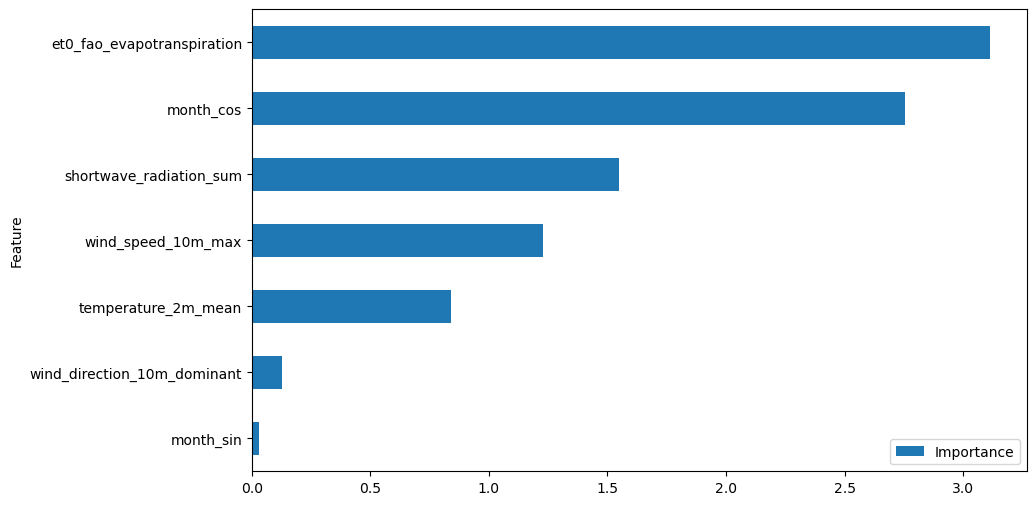

In [80]:
pipe = make_pipeline(preprocess, models["Logistic Regression"])
pipe.fit(X_train, y_train)

coefficients = pipe.named_steps['logisticregression'].coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

# Oak to write something on feature importance

For the chosen model SVM, let us optimize the training parameter.

In [81]:
param_grid = {"C": np.logspace(-1, 2, 4)}

results_dict = {} 

for c_value in param_grid["C"]:
    pipe = make_pipeline(preprocess, SVC(C=c_value, random_state = 522))
    results_dict[c_value] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True
    )   
best_SVC_model_df = pd.DataFrame(results_dict).T
best_SVC_model_df

['0.565 (+/- 0.009)', '0.292 (+/- 0.003)', '0.854 (+/- 0.004)', '0.855 (+/- 0.001)']
['0.490 (+/- 0.011)', '0.241 (+/- 0.003)', '0.859 (+/- 0.008)', '0.863 (+/- 0.002)']
['0.577 (+/- 0.016)', '0.226 (+/- 0.008)', '0.861 (+/- 0.008)', '0.869 (+/- 0.002)']
['1.102 (+/- 0.061)', '0.218 (+/- 0.004)', '0.859 (+/- 0.007)', '0.876 (+/- 0.002)']


,fit_time,score_time,test_score,train_score
0.1,0.565 (+/- 0.009),0.292 (+/- 0.003),0.854 (+/- 0.004),0.855 (+/- 0.001)
1.0,0.490 (+/- 0.011),0.241 (+/- 0.003),0.859 (+/- 0.008),0.863 (+/- 0.002)
10.0,0.577 (+/- 0.016),0.226 (+/- 0.008),0.861 (+/- 0.008),0.869 (+/- 0.002)
100.0,1.102 (+/- 0.061),0.218 (+/- 0.004),0.859 (+/- 0.007),0.876 (+/- 0.002)


Best Model is the with C=10.0, since it gives highest test_score

In [82]:
C_best_value = 10
opt_pipe = make_pipeline(preprocess, SVC(C=C_best_value, random_state = 522))
opt_pipe.fit(X_train, y_train)
opt_pipe.score(X_test, y_test)

0.862515163768702

The eventual classification model can produce 0.863

## Similar Pipe is run for snow prediction
# But instead of just returning the model accuracy, we take a look at model recall/ precision too since the positive data is sparse

In [86]:
y_train = train_df['is_snow']
y_test = test_df['is_snow']

In [87]:
def cross_val_model(model, X_train, y_train, classification_metrics):
    pipe = make_pipeline(preprocess, models[model])
    return pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True, scoring=classification_metrics)).agg(['mean']).round(3).T


In [91]:
cross_val_results = {}
classification_metrics = ["accuracy", "precision", "recall", "f1"]
del models['dummy'] # Dummy model is removed since recall/precision calculation will be affected
models['SVC_bal'] = SVC(random_state=522, class_weight="balanced")
models['Log_bal'] = LogisticRegression(random_state=522, max_iter=1000, class_weight="balanced")

for model_name in models.keys():
    model = models[model_name]
    pipe = make_pipeline(preprocess, model_name)
    cross_val_results[model_name] = cross_val_model(model_name, X_train, y_train, classification_metrics)   
    print("Done with", model_name)

Done with Decision Tree
Done with KNN
Done with RBF SVM
Done with Logistic Regression
Done with SVC_bal
Done with Log_bal


In [92]:
pd.concat(
    cross_val_results,
    axis='columns'
)

,Decision Tree,KNN,RBF SVM,Logistic Regression,SVC_bal,Log_bal
,mean,mean,mean,mean,mean,mean
fit_time,0.037,0.007,0.136,0.023,0.304,0.025
score_time,0.001,0.043,0.075,0.004,0.151,0.001
test_accuracy,0.952,0.958,0.962,0.947,0.901,0.884
train_accuracy,1.000,0.970,0.963,0.947,0.904,0.885
test_precision,0.590,0.735,0.849,0.612,0.367,0.332
train_precision,1.000,0.877,0.870,0.607,0.379,0.334
test_recall,0.621,0.443,0.446,0.279,0.937,0.942
train_recall,1.000,0.568,0.447,0.271,0.968,0.949
test_f1,0.605,0.551,0.583,0.380,0.527,0.491


Based on the F1 Score, we will choose RBF SVM
However, if the cost of missing out a snow day is much higher than mis-classifying a non-snow day as snow day, we should go with SVC balanced model, as that gives recall of more than 09 while maintaining F1 above 0.5.

In [97]:
# We chose the SVC balanced and run the hyperparameter optimization, just like the rain case. 

param_grid = {"svc__C": 10.0**np.arange(-3,3)}
svc_bal_pipe = make_pipeline(preprocess, models['SVC_bal'])

grid_search = GridSearchCV(svc_bal_pipe,param_grid=param_grid,n_jobs=-1,return_train_score=True,scoring=classification_metrics,refit="f1")
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            random_state=522))]),
             n_jobs=-1,
             param_grid={'svc__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [98]:
grid_search.best_params_

{'svc__C': 100.0}

In [100]:
svc_pipe_final = make_pipeline(preprocess, SVC(C=100, random_state=123, class_weight="balanced")) 
svc_pipe_final.fit(X_train, y_train)


from sklearn.metrics import classification_report
print(
    classification_report(
        y_test, svc_pipe_final.predict(X_test), labels=[True,False]
    )
)

              precision    recall  f1-score   support

        True       0.43      0.88      0.58       143
       False       0.99      0.93      0.96      2330

    accuracy                           0.93      2473
   macro avg       0.71      0.91      0.77      2473
weighted avg       0.96      0.93      0.94      2473

